In [2]:
# Стандартні бібліотеки
import os


# Зовнішні бібліотеки

import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from keras.models import load_model
from keras.preprocessing.image import  img_to_array
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, zoomed_inset_axes

In [3]:
channels = 1
cropped_width = 498
cropped_height = 300
upscale_factor = 3

input_width = cropped_width // upscale_factor
input_height = cropped_height  // upscale_factor

TEST_FOLDER_PATH  = 'D:\\KPI\\Bachelor_thesis\\code\\data\\images\\test'
TEST_FOLDER_PATH  = 'D:\\KPI\\Bachelor_thesis\\code\\bot\\images\\control_examples\\raw'
TRAIN_FOLDER_PATH = 'D:\\KPI\\Bachelor_thesis\\code\\data\\images\\train'
VAL_FOLDER_PATH   = 'D:\\KPI\\Bachelor_thesis\\code\\data\\images\\val'

RAW_TEST_FOLDER_PATH  = 'D:\\KPI\\Bachelor_thesis\\code\\data\\raw_images\\test'
RAW_TRAIN_FOLDER_PATH = 'D:\\KPI\\Bachelor_thesis\\code\\data\\raw_images\\train'
RAW_VAL_FOLDER_PATH   = 'D:\\KPI\\Bachelor_thesis\\code\\data\\raw_images\\val'

In [4]:
model = load_model('D:\\KPI\\Bachelor_thesis\\code\\models\\RDB_Sigmoid\\RDB_Sigmoid_40.h5')

In [5]:
def plot_results(img, prefix, title, z1=200, z2=300, z3=150, z4=250):
    
    img_array = img_to_array(img)                          # Here, images are prepared to be plotted
    img_array = img_array.astype("float32") / 255.0        # by transforming them into arrays and
                                                           # scaling their values.

    _figure, parent = plt.subplots()                        # A subplot is created for the original
                                                           # image and the zoomed image.
        
        
    parent.imshow(img_array[::-1], origin="lower")         # The reason why we want to plot the figure
                                                           # in reverse here is because when we use
    #plt.yticks(visible=False) (Optional)                  # img_to_array, the height and width
    #plt.xticks(visible=False) (Optional)                  # locations get inverted. The "origin"
                                                           # parameter specifies the location of the            
    plt.title(title)                                       # origin point (0, 0). Left lower corner
                                                           # in this case.
    
    
    inset = zoomed_inset_axes(parent, 2, loc='upper left') # Define the inset axes based on the parent
    inset.imshow(img_array[::-1], origin="lower")          # axes and specify the zoom value (2x, 3x, etc).
                                                           # We also specify the location for the zoom
                                                           # image, upper left corner in this case.

    x1, x2, y1, y2 = z1, z2, z3, z4                        

    inset.set_xlim(x1, x2)                                 # Specify the X axis coordinates for the 
                                                           # zoom image.
        
    inset.set_ylim(y1, y2)                                 # Specify the Y axis coordinates for the
                                                           # zoom image.
        
    plt.yticks(visible=False)                              # Remove the zoomed area axes numbers.
    plt.xticks(visible=False)


    mark_inset(parent, inset, loc1=1, loc2=3, fc="none", ec="blue")  # Draw extra lines indicating the
                                                                     # location of the zoom image. "loc1"
    plt.show()                                                       # and "loc2" are corners of the inset
                                                                     # axes, "fc" and "ec" are lines colors.

In [6]:
total_bicubic_psnr = 0.0      # Variable for total average LR-HR PSNR.
total_test_psnr = 0.0         # Variable for total average ER-HR PSNR.

valid_path = TEST_FOLDER_PATH                                           # Path of the folder containing  
                                                                        # images for validation.
    
valid_img_paths = sorted([os.path.join(valid_path,img_name)             # List comprehension to get the
                        for img_name in os.listdir(valid_path)])        # full path of the images.

visualize_results = []     
# 9, 15, 17, 23, 32, 39, 50, 637                          
for _ in (0, 1, 2, 3, 4):                              # Indices of required image     
    visualize_results.append(valid_img_paths[_])                        # samples for validation.
        
z = {1: [150, 300, 230, 330],
     3: [280, 380, 150, 250],
     4: [200, 300, 180, 280], 
     5: [200, 330, 175, 300]}

1/1 [==============================] - 1s 1s/step


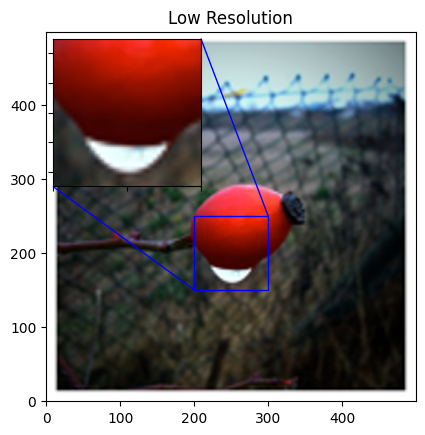

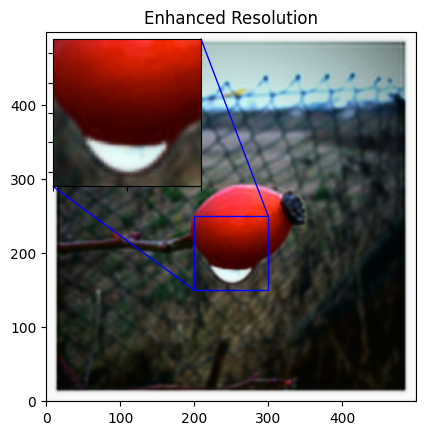

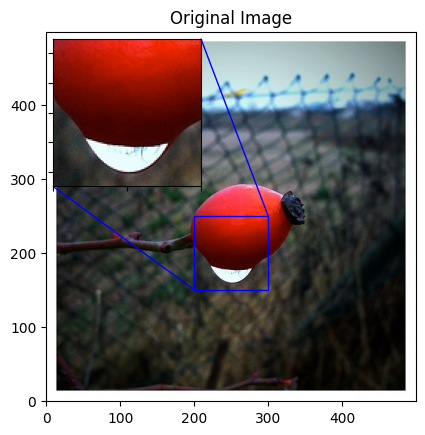

PSNR між LR та HR: 27.479351
PSNR між ER та HR: 27.803116



1/1 [==============================] - 1s 896ms/step


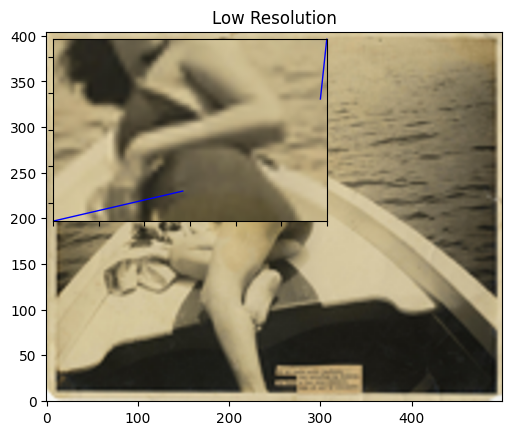

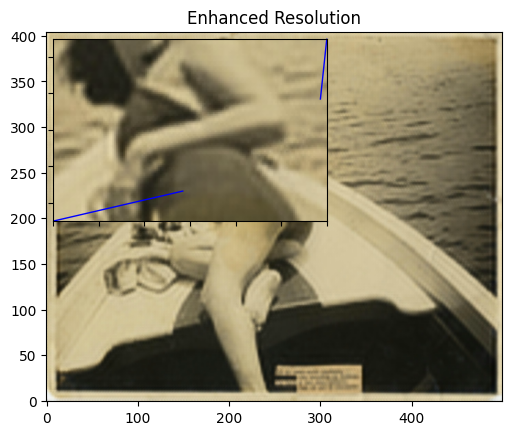

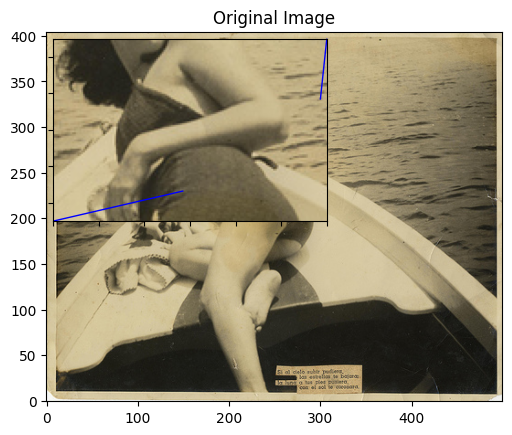

PSNR між LR та HR: 27.323317
PSNR між ER та HR: 27.083443



1/1 [==============================] - 1s 553ms/step


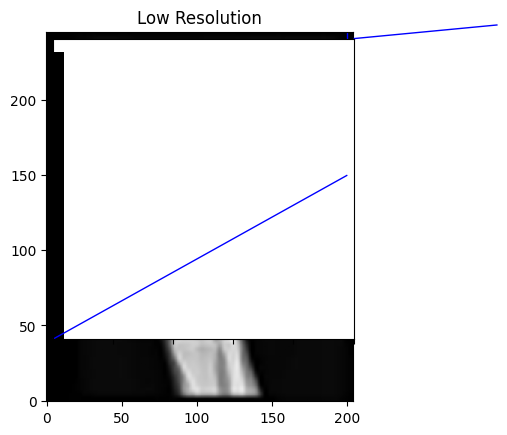

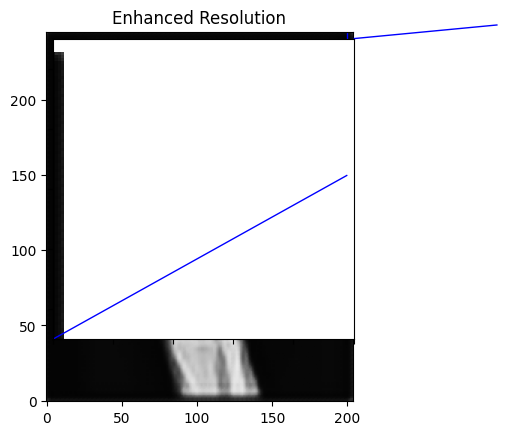

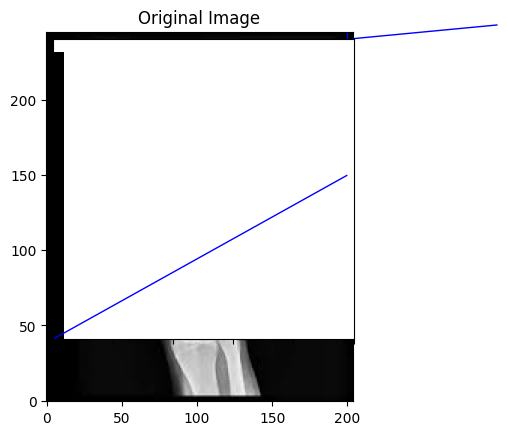

PSNR між LR та HR: 28.269054
PSNR між ER та HR: 27.877861



1/1 [==============================] - 1s 512ms/step


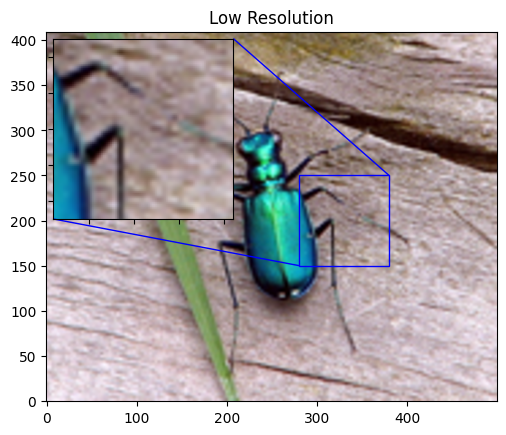

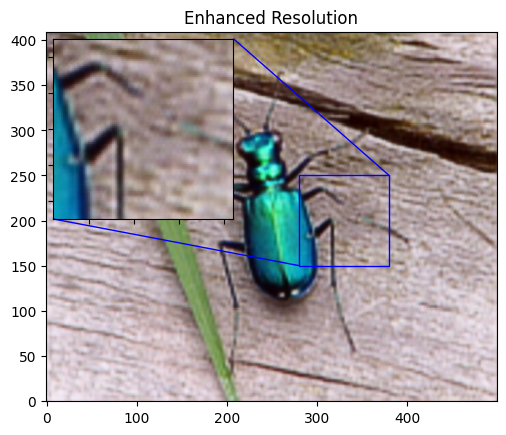

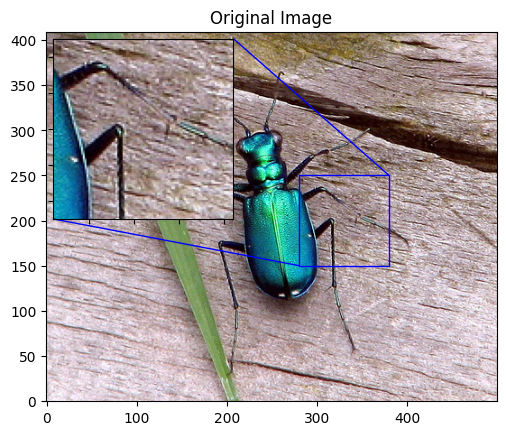

PSNR між LR та HR: 21.002518
PSNR між ER та HR: 20.773464



1/1 [==============================] - 0s 490ms/step


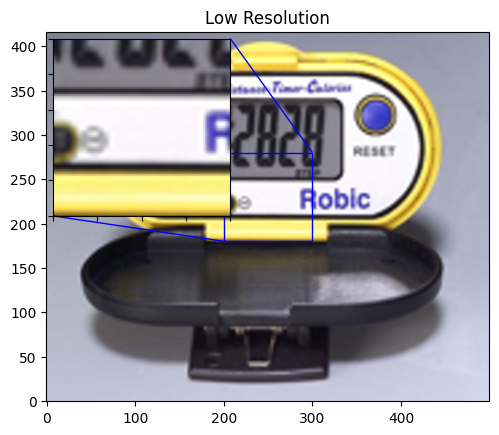

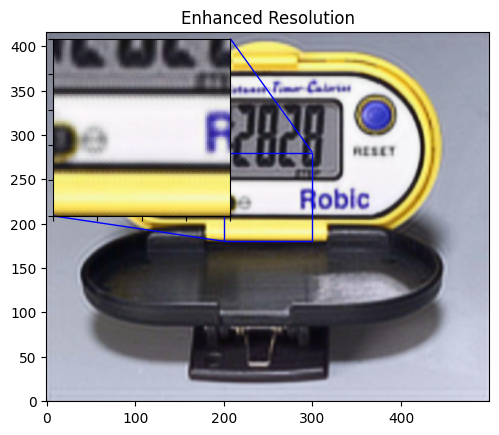

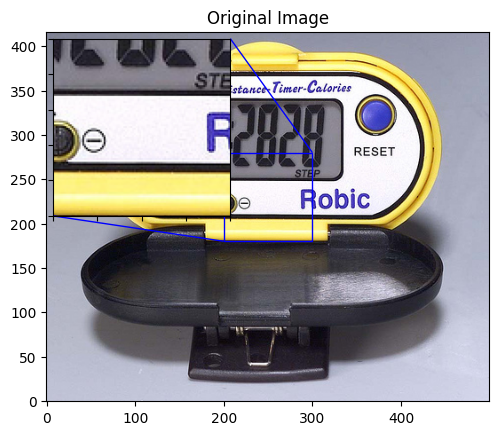

PSNR між LR та HR: 22.285189
PSNR між ER та HR: 22.024813





In [7]:
for index, _ in enumerate(visualize_results):
    
    
    """ -------- VISUAL ASSESSMENT -------- """
    
    
    HR_image = PIL.Image.open(_)
    
    LR_image = HR_image.resize((HR_image.size[0] // upscale_factor,   # Donwscaling to LR occurs here.
                                HR_image.size[1] // upscale_factor),
                               PIL.Image.BICUBIC)
    
    ycbcr = LR_image.convert("YCbCr")       # Here, we converted the image to YCbCr because we
    y, cb, cr = ycbcr.split()               # need the Y channel for our model. We did not convert
    y = img_to_array(y)                     # it to YUV because we can't in PIL and Y in YCbCr is
    y = y.astype("float32") / 255.0         # the same as in YUV.
                                            
    model_input = y.reshape(1, y.shape[0], y.shape[1], y.shape[2])      # (Batch, Width, Height, Channels)
    
    output = model.predict(model_input)
    output = output[0]                                            # (Width, Height, Channels)
    output *= 255.0
    output = output.clip(0, 255)
    output = output.reshape((output.shape[0], output.shape[1]))   # (Width, Height)
    output = PIL.Image.fromarray(np.uint8(output))
    output = output.resize(HR_image.size, PIL.Image.Resampling.NEAREST)   # This step is necessary to
                                                                          # fill missing pixels from
                                                                          # the prediction process.
            
    cb = cb.resize(output.size, PIL.Image.Resampling.BICUBIC)          
    cr = cr.resize(output.size, PIL.Image.Resampling.BICUBIC)
    
    ER_image = PIL.Image.merge("YCbCr", (output, cb, cr))
    ER_image = ER_image.convert("RGB")
     
    LR_image = LR_image.resize(ER_image.size, PIL.Image.Resampling.BICUBIC)  # Resizing LR for plotting.
                                                                             
    if index in z.keys():      # Custom zoom values for each image if given in 'z' dictionary.
                               # If not given, use default zoom values in the 'else' statement.
            
        plot_results(LR_image, index, 'Low Resolution', z[index][0], z[index][1], z[index][2], z[index][3])

        plot_results(ER_image, index, 'Enhanced Resolution', z[index][0], z[index][1], z[index][2], z[index][3])

        plot_results(HR_image, index, 'Original Image', z[index][0], z[index][1], z[index][2], z[index][3])
        
    else:                      # Default zoom values: 200, 300, 150, 250.
        
        plot_results(LR_image, index, 'Low Resolution')

        plot_results(ER_image, index, 'Enhanced Resolution')

        plot_results(HR_image, index, 'Original Image')
    
    
    """ -------- ACCURACY CALCULATION --------"""
    
    
    LR_arr = img_to_array(LR_image)
    HR_arr = img_to_array(HR_image)
    ER_arr = img_to_array(ER_image)
    
    bicubic_psnr = tf.image.psnr(LR_arr, HR_arr, max_val=255)
    test_psnr = tf.image.psnr(ER_arr, HR_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print("PSNR між LR та HR: %f" % bicubic_psnr)
    print("PSNR між ER та HR: %f" % test_psnr)
    print(f'\n\n')

In [8]:
print(f"Середній PSNR між LR та HR зображеннями = {round(float((total_bicubic_psnr / (index + 1))), 3)}")
print(f"Середній PSNR між ER та HR зображеннями = {round(float((total_test_psnr / (index + 1))), 3)}")

Середній PSNR між LR та HR зображеннями = 25.272
Середній PSNR між ER та HR зображеннями = 25.113
